The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).<br>
In this homework, we will use Credit Card Data from book "Econometric Analysis".<br> 
Here is the [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv) to the dataset


In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

import wget

%matplotlib inline

In [2]:
# download the file from the url provided
# url =  'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
# file = wget.download(url)

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


**Data Preparation**<br>
Create the target variable by mapping yes to 1 and no to 0.<br>
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [4]:
# create a lambda expression mapping yes to 1 and no to 0
x = lambda x: 0 if x == 'no' else 1
df.card = df.card.apply(x).values
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
# split the data into train/val/test set
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

#reset the index on the separate dataset
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

# create the target variable
y_train  = df_train.card
y_val = df_val.card
y_test = df_test.card

# drop the target variable from the train, test and validation dataset
del df_train['card']
del df_val['card']
del df_test['card']

In [6]:
#verify the split was done properly
len(df_train), len(df_test), len(df_val)

(791, 264, 264)

**Question 1**<br>
ROC AUC could also be used to evaluate feature importance of numerical variables.<br>

Let's do that<br>

For each numerical variable, use it as score and compute AUC with the card variable.<br>
Use the training dataset for that.<br>
If your AUC is < 0.5, invert this variable by putting "-" in front<br>

Which numerical variable has the highest AUC?

In [7]:
#select the numerical variables
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)

In [8]:
for v in numerical:
    auc = roc_auc_score(y_train, df_train[v])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])
    print('%15s, %.3f' % (v, auc))

        reports, 0.717
            age, 0.524
         income, 0.591
          share, 0.989
    expenditure, 0.991
     dependents, 0.533
         months, 0.529
     majorcards, 0.534
         active, 0.604


The numerical variable **expenditure** has the highest AUC

**Training the moel**<br>
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:<br>
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>

In [9]:
# create a dictionary of the train dataframe and apply one hot encoding
train_dict = df_train.to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_train

array([[1.700000e+01, 4.050000e+01, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 2.990431e-04],
       [4.000000e+00, 3.233333e+01, 4.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 2.000000e-04],
       [7.000000e+00, 2.916667e+01, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 3.820546e-02],
       ...,
       [1.000000e+00, 2.475000e+01, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 8.070774e-02],
       [7.000000e+00, 5.691667e+01, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 6.289540e-02],
       [8.000000e+00, 2.458333e+01, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 5.454546e-04]])

In [10]:
# train the model
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

**Question 2**<br>
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [11]:
val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred).round(3)


0.995

The AUC is **0.995**

**Question 3**<br>

Now let's compute precision and recall for our model.<br>

>* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01<br>
>* For each threshold, compute precision and recall<br>
>* Plot them<br>

At which threshold precision and recall curves intersect?

In [12]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    
    return df_scores

In [13]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [14]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

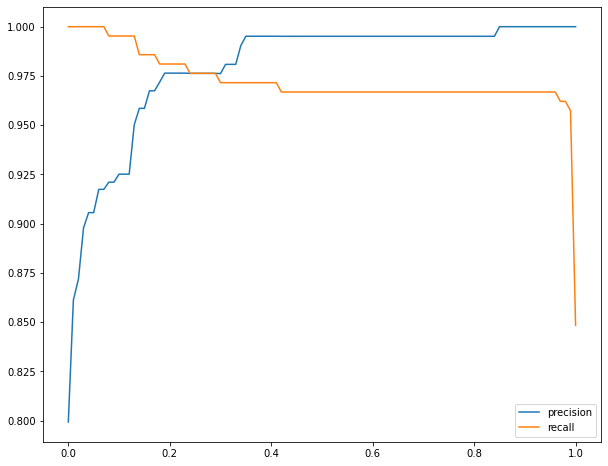

In [15]:
plt.figure(figsize = (10, 8))
plt.plot(df_scores.threshold, df_scores.precision, label = 'precision')
plt.plot(df_scores.threshold, df_scores.recall, label = 'recall')

plt.legend()
plt.show()

The precision and recall curve intersect at approx **0.3** threshold

**Question 4**<br>

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often<br> combined into the F1 score - a metrics that takes into account both<br>

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set<br>

At which threshold F1 is maximal?

In [16]:
# COMPUTING F1 SCORES FOR ALL THRESHOLDS:
df_scores['f1_score'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,f1_score
0,0.00,211,53,0,0,0.799242,1.0,0.888421
1,0.01,211,34,0,19,0.861224,1.0,0.925439
2,0.02,211,31,0,22,0.871901,1.0,0.931567
3,0.03,211,24,0,29,0.897872,1.0,0.946188
4,0.04,211,22,0,31,0.905579,1.0,0.950450


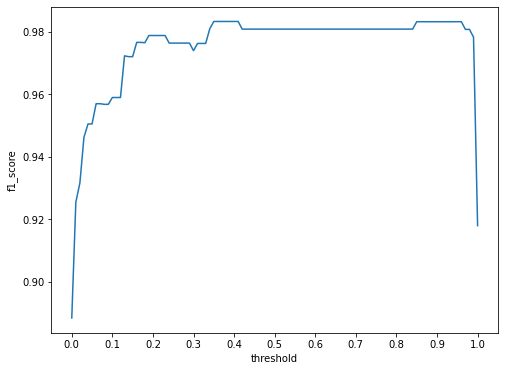

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(df_scores.threshold, df_scores.f1_score)
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel('threshold')
plt.ylabel('f1_score')
plt.show()

The F1 Score is maximal at approx **0.4** and **0.8** threshold

**Question 5**<br>

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:<br>

> KFold(n_splits = 5, shuffle = True, random_state = 1)<br>
>>* Iterate over different folds of df_full_train<br>
>>* Split the data into train and validation<br>
>>* Train the model on train with these parameters: LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)<br>
>>* Use AUC to evaluate the model on validation<br>

How large is standard devidation of the AUC scores across different folds?<br>

In [18]:
def train(df, y):
    df_dicts = df.to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(df_dicts)

    model = LogisticRegression(solver = 'liblinear', C = 1.0)
    model.fit(X_train, y)

    return dv, model

In [19]:

def predict(df, dv, model):
    df_dicts = df.to_dict(orient = 'records')

    X = dv.transform(df_dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
auc_scores = []

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_KF = df_full_train.iloc[train_idx]
    df_val_KF = df_full_train.iloc[val_idx]

    y_train_KF = df_train_KF.card
    y_val_KF = df_val_KF.card

    dv_, model_ = train(df_train_KF, y_train_KF)
    y_pred_KF = predict(df_val_KF, dv_, model_)

    auc = roc_auc_score(y_val_KF, y_pred_KF)
    auc_scores.append(auc)

print('%.3f +- %.3f' % (np.mean(auc_scores), np.std(auc_scores)))

1.000 +- 0.000


**Question 6**<br>

Now let's use 5-Fold cross-validation to find the best parameter C<br>

Iterate over the following C values: [0.01, 0.1, 1, 10]<br>

>* Initialize KFold with the same parameters as previously<br>
>* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)<br>
>* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)<br>

Which C leads to the best mean score?

In [21]:
#@ INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card
        y_val = df_val.card

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C = %4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 0.01, 1.000 +- 0.000
C =  0.1, 1.000 +- 0.000
C =    1, 1.000 +- 0.000
C =   10, 1.000 +- 0.000
